In [1]:
# Install necessary libraries.

!pip install gymnasium
!pip install gymnasium[atari]
!pip install stable-baselines3[extra]
!pip install tensorflow
!pip install opencv-python

  Using cached Shimmy-0.2.1-py3-none-any.whl (25 kB)
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
  Using cached Shimmy-1.3.0-py3-none-any.whl (37 kB)
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 0.2.1
    Uninstalling Shimmy-0.2.1:
      Successfully uninstalled Shimmy-0.2.1


In [2]:
# Import necessary libraries.

import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold, EvalCallback
import torch as th
import cv2
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
Action: 2, Reward: 0.0, Episode Done: False
1/1 [==============================] - 0s 28ms/step
Action: 3, Reward: 0.0, Episode Done: False
1/1 [==============================] - 0s 28ms/step
Action: 2, Reward: 0.0, Episode Done: False
1/1 [==============================] - 0s 29ms/step
Action: 0, Reward: 0.0, Episode Done: False
1/1 [==============================] - 0s 25ms/step
Action: 5, Reward: 0.0, Episode Done: False
1/1 [==============================] - 0s 25ms/step
Action: 2, Reward: 0.0, Episode Done: False
1/1 [==============================] - 0s 28ms/step
Action: 5, Reward: 0.0, Episode Done: False
1/1 [==============================] - 0s 28ms/step
Action: 3, Reward: 0.0, Episode Done: False
1/1 [==============================] - 0s 25ms/step
Action: 4, Reward: 0.0, Episode Done: False
1/1 [==============================] - 0s 28ms/step
Action: 1, Reward: 0.0, Episode D

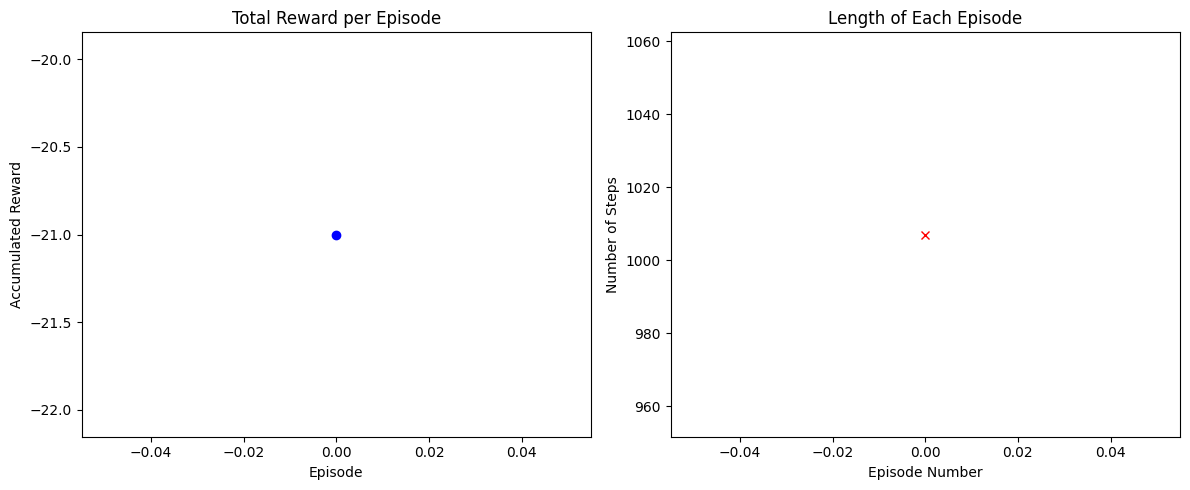

In [3]:
# Implement Q-Learning class

import gym
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam

# Function to preprocess raw game frames for neural network input
def preprocess_frame(frame):
    # If frame is a tuple (due to environment specifics), extract the first element (the image)
    frame = frame[0] if isinstance(frame, tuple) else frame

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert the image to grayscale to reduce computation
    cropped_frame = gray_frame[34:194]                    # Crop the image to focus on the relevant game area (remove score and borders)
    resized_frame = cv2.resize(cropped_frame, (84, 84))   # Resize the image to a standard size
    normalized_frame = resized_frame / 255.0              # Normalize pixel values for better NN performance
    return np.reshape(normalized_frame, (1, 84, 84, 1))   # Reshape the frame to fit the input shape

# Q-Learning class
class QLearning:
    def __init__(self, state_dimensions, number_of_actions, lr=0.01, discount_factor=0.8):
        self.state_dimensions = state_dimensions
        self.number_of_actions = number_of_actions
        self.lr = lr
        self.discount_factor = discount_factor
        self.network = self.create_network()

    # Function to create the neural network model for function approximation
    def create_network(self):
        neural_network = Sequential()

        # Convolutional layers to process the input game frames
        neural_network.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=self.state_dimensions))
        neural_network.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
        neural_network.add(Conv2D(64, (3, 3), activation='relu'))
        neural_network.add(Flatten())

        # Dense layers for decision making
        neural_network.add(Dense(512, activation='relu'))
        neural_network.add(Dense(self.number_of_actions, activation='linear'))

        # Compile the model with mean squared error loss and Adam optimizer
        neural_network.compile(loss='mse', optimizer=Adam(learning_rate=self.lr))

        return neural_network

    # Function to update the network based on experience (state, action, reward, next state)
    def learn_from_experience(self, current_state, action_taken, received_reward, next_state, completion_status):
        future_reward_estimate = np.max(self.network.predict(next_state)[0])
        updated_target = received_reward + self.discount_factor * future_reward_estimate * (1 - completion_status)    # Calculate target value using Bellman equation
        target_values = self.network.predict(current_state)
        target_values[0][action_taken] = updated_target

        # Train the model with updated target values
        self.network.fit(current_state, target_values, epochs=1, verbose=0)

    # Function to select action based on epsilon-greedy strategy
    def select_action(self, current_state, exploration_rate):
        # Exploration: choose a random action with probability epsilon
        if np.random.rand() <= exploration_rate:
            return np.random.randint(self.number_of_actions)

        # Exploitation: choose the best action based on predictions
        estimated_values = self.network.predict(current_state)
        return np.argmax(estimated_values[0])


# Create environment and Q-learning agent
env = gym.make('Pong-v0')
state_shape = (84, 84, 1)
action_count = env.action_space.n  # Number of actions in the Pong env
q_learning_agent = QLearning(state_shape, action_count)


total_episodes = 2         # Total number of episodes for training
exploration_rate = 1.0      # Initial exploration rate (100% exploration at the start)
exploration_rate_minimum = 0.01  # Minimum exploration rate (limits the decrease of exploration)
exploration_decay_rate = 0.995  # Decay rate for exploration (reduces exploration over time)


# Run episodes
for episode in range(total_episodes):
    initial_state = env.reset()
    state = preprocess_frame(initial_state)
    print(f"Initial state shape: {state.shape}")
    episode_done = False        # Flag to indicate if the episode is complete

    while not episode_done:
        chosen_action = q_learning_agent.select_action(state, exploration_rate)
        new_state_raw, reward, episode_done, info = env.step(chosen_action)
        new_state = preprocess_frame(new_state_raw)

        print(f"Action: {chosen_action}, Reward: {reward}, Episode Done: {episode_done}")

        # Update the Q-Learning agent with the new experience
        q_learning_agent.learn_from_experience(state, chosen_action, reward, new_state, episode_done)
        state = new_state       # Update the current state

    # Update the exploration rate for the next episode
    exploration_rate = max(exploration_rate_minimum, exploration_rate * exploration_decay_rate)


q_learning_agent.network.save("pong_q_learning_model_modified.h5")


# Evaluate the model

def evaluate_model(trained_model, env, number_of_evaluation_episodes):
    rewards_per_episode = []
    lengths_of_episodes = []

    for episode_number in range(number_of_evaluation_episodes):
        initial_state = env.reset()
        current_state = preprocess_frame(initial_state[0] if isinstance(initial_state, tuple) else initial_state)
        episode_done = False
        accumulated_reward = 0
        episode_length = 0

        while not episode_done:
            chosen_action = np.argmax(trained_model.predict(current_state)[0])
            next_state_raw, reward, episode_done, _ = env.step(chosen_action)
            current_state = preprocess_frame(next_state_raw)

            accumulated_reward += reward
            episode_length += 1

        rewards_per_episode.append(accumulated_reward)
        lengths_of_episodes.append(episode_length)
        print(f"Episode {episode_number + 1}: Reward: {accumulated_reward}, Length: {episode_length}")

    average_reward = sum(rewards_per_episode) / len(rewards_per_episode)
    print(f"Average Reward over {number_of_evaluation_episodes} episodes: {average_reward}")

    return rewards_per_episode, lengths_of_episodes

# Evaluate the model
evaluated_rewards, evaluated_lengths = evaluate_model(q_learning_agent.network, env, 1)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting the total rewards per episode
plt.subplot(1, 2, 1)
plt.plot(evaluated_rewards, marker='o', color='b')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')

# Plotting the lengths of each episode
plt.subplot(1, 2, 2)
plt.plot(evaluated_lengths, marker='x', color='r')
plt.title('Length of Each Episode')
plt.xlabel('Episode Number')
plt.ylabel('Number of Steps')

plt.tight_layout()
plt.show()
